In [19]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
import seaborn as sb
import os
import gdown

In [20]:
# Downloading training dataset
train_file_id = '1-e3oa8IAgmjkikjirxHObjDXpiY0g51i'
train_file_name = 'Gotem_Pumpkins_Train.csv'  # New file name
train_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_url, train_file_name, quiet=False)
training_data = pd.read_csv(train_file_name)

# Downloading testing dataset
test_file_id = '1GMoK_4HOLIjCLuIdRD6pmLhSy1ymykQP'
test_file_name = 'Freyja_Pumpkins_Test.csv'
test_url = f'https://drive.google.com/uc?id={test_file_id}'
gdown.download(test_url, test_file_name, quiet=False)
testing_data = pd.read_csv(test_file_name)

Downloading...
From: https://drive.google.com/uc?id=1-e3oa8IAgmjkikjirxHObjDXpiY0g51i
To: /content/Gotem_Pumpkins_Train.csv
100%|██████████| 216k/216k [00:00<00:00, 6.78MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GMoK_4HOLIjCLuIdRD6pmLhSy1ymykQP
To: /content/Freyja_Pumpkins_Test.csv
100%|██████████| 53.7k/53.7k [00:00<00:00, 57.7MB/s]


In [21]:
# Function to convert text to numbers
def extract(text):
    try:
        return float(text.split()[0])
    except:
        return np.nan  # Return NaN if conversion fails

In [22]:
# Display the first few rows
print(training_data.head())

   Unnamed: 0    Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  \
0           0   84930   1204.448           508.7883           213.0266   
1           1  103343   1275.261           521.4694           252.8941   
2           2   98350   1269.539           526.2346           238.4702   
3           3   69517   1059.538           429.8407           206.8250   
4           4   80011   1182.947           501.9065           204.7531   

   Convex_Area  Equiv_Diameter  Eccentricity  Solidity  Extent  Roundness  \
0        85665        328.8407        0.9081    0.9914  0.5482     0.7357   
1       104156        362.7401        0.8745    0.9922  0.7457     0.7985   
2        99184        353.8688        0.8914    0.9916  0.5919     0.7668   
3        70493        297.5093        0.8766    0.9862  0.6623     0.7782   
4        80902        319.1758        0.9130    0.9890  0.7374     0.7185   

   Aspect_Ration  Compactness          Class  
0         2.3884       0.6463  Ürgüp Sivrisi 

In [23]:
#assigning the classifications numbers instead of names
training_data['Class'] = training_data['Class'].map({'Ürgüp Sivrisi': 1, 'Çerçevelik': 0})
testing_data['Class'] = testing_data['Class'].map({'Ürgüp Sivrisi': 1, 'Çerçevelik': 0})

In [24]:
x_train = training_data.drop(columns=['Class']).values
y_train = training_data['Class'].values

x_test = testing_data.drop(columns=['Class']).values
y_test = testing_data['Class'].values

#z score normalisation of training data- feature scaling
x_mu = np.mean(x_train,axis=0)
x_sigma = np.std(x_train, axis=0)
x_sigma[x_sigma == 0] = 1
x_norm = (x_train - x_mu)/x_sigma


In [25]:
#defining sigmoid function
def sigmoid(z):
  g = 1/(1 + np.exp(-z))
  return g


In [26]:
#compute total cost of all iterations
def compute_cost_logistic(X, y, w, b, lambda_ = 1):
    m,n  = X.shape
    cost = 0.
    #cost function
    for i in range(m):
        z_i = np.dot(X[i], w)+b
        f_wb_i = sigmoid(z_i)
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)

    cost/= m
    #regularization
    reg_cost = 0
    for j in range(n):
        reg_cost+= (w[j]**2)
    reg_cost = (lambda_/(2*m))*reg_cost

    total_cost = cost + reg_cost
    return total_cost

In [27]:
#function to compute gradient of a single iteration
def compute_gradient_logistic(X, y, w, b):
  m,n = X.shape
  dj_dw = np.zeros((n,))
  dj_db = 0.

  for i in range(m):
    f_wb_i = sigmoid(np.dot(X[i],w) + b)
    err_i  = f_wb_i  - y[i]
    for j in range(n):
      dj_dw[j] = dj_dw[j] + err_i*X[i,j]
      dj_db = dj_db + err_i
  #for all examples
  dj_dw = dj_dw/m
  dj_db = dj_db/m

  return dj_db, dj_dw



In [28]:
#gradient descent
def grad_desc(X, y, w_in, b_in, alpha, iters):
  J_history = []
  w = copy.deepcopy(w_in)
  b = b_in

  for i in range(1,iters+1):
    #updating w and b values
    dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)
    w = w - alpha * dj_dw
    b = b - alpha * dj_db
    if i<1000:
      J_history.append( compute_cost_logistic(X, y, w, b) )
    if i% math.ceil(iters / 10) == 0:
      print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

  return w, b, J_history

In [29]:
#normalising the testing data
x_mu_t = np.mean(x_test,axis=0)
x_sigma_t = np.std(x_test, axis=0)
x_sigma_t[x_sigma_t == 0] = 1
x_norm_t = (x_test - x_mu_t)/x_sigma_t


In [30]:
#initialising
w_init = np.zeros(x_train.shape[1])
b_init = 0.
iterations = 10000
lambda_ = 0.1

#finding optimal alpha
#alphas = [0.001, 0.003, 0.01, 0.03, 0.1,0.3,1]
alphas = [0.001,0.005,0.01,0.05,0.1,0.5,1]
alpha_iter = 200
best_alpha = None
lowest_cost = float('inf')
J_hist_alpha = []

for alpha in alphas:
    w_final, b_final, J_hist = grad_desc(x_norm, y_train, w_init, b_init, alpha, alpha_iter)
    final_cost = J_hist[-1]
    J_hist_alpha.append(final_cost)
    print(f"Alpha: {alpha}, Final Cost: {final_cost}")

    if final_cost < lowest_cost:
        lowest_cost = final_cost
        best_alpha = alpha

print(f"Optimal Learning Rate: {best_alpha}")


Iteration   20: Cost 0.679809899456042   
Iteration   40: Cost 0.667178571665703   
Iteration   60: Cost 0.6552129126850232   
Iteration   80: Cost 0.6438741643823291   
Iteration  100: Cost 0.6331252303602218   
Iteration  120: Cost 0.6229307655698274   
Iteration  140: Cost 0.6132572261959129   
Iteration  160: Cost 0.6040728859824154   
Iteration  180: Cost 0.5953478249873642   
Iteration  200: Cost 0.5870538963418384   
Alpha: 0.001, Final Cost: 0.5870538963418384
Iteration   20: Cost 0.6329843405527911   
Iteration   40: Cost 0.5868420075185923   
Iteration   60: Cost 0.5509415437533395   
Iteration   80: Cost 0.5225270369904436   
Iteration  100: Cost 0.4996444917569649   
Iteration  120: Cost 0.48091448412933024   
Iteration  140: Cost 0.4653553935887751   
Iteration  160: Cost 0.4522589916804811   
Iteration  180: Cost 0.4411060313770332   
Iteration  200: Cost 0.4315094869417605   
Alpha: 0.005, Final Cost: 0.4315094869417605
Iteration   20: Cost 0.5865753439393457   
Iteratio

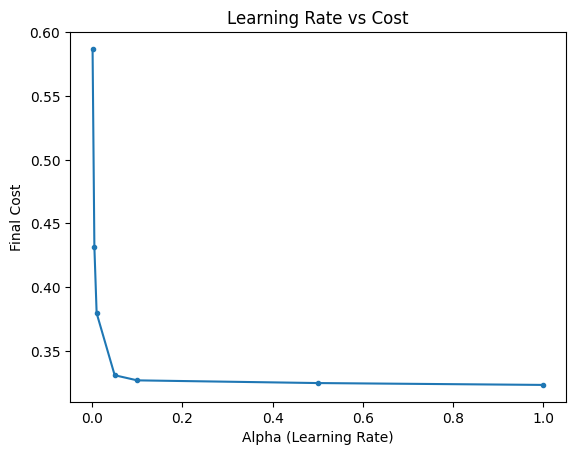

In [31]:

#plotting variation of final cost with learning rate
plt.plot(alphas, J_hist_alpha, marker='.')
plt.xlabel("Alpha (Learning Rate)")
plt.ylabel("Final Cost")
plt.title("Learning Rate vs Cost")
plt.show()

In [32]:
#logistic regression
w_final, b_final, J_hist = grad_desc(x_norm, y_train, w_init, b_init, best_alpha, iterations)


Iteration 1000: Cost 0.31719390434072603   
Iteration 2000: Cost 0.31719390434072603   
Iteration 3000: Cost 0.31719390434072603   
Iteration 4000: Cost 0.31719390434072603   
Iteration 5000: Cost 0.31719390434072603   
Iteration 6000: Cost 0.31719390434072603   
Iteration 7000: Cost 0.31719390434072603   
Iteration 8000: Cost 0.31719390434072603   
Iteration 9000: Cost 0.31719390434072603   
Iteration 10000: Cost 0.31719390434072603   


In [33]:
sigmoid_predictions = sigmoid(np.dot(x_norm_t, w_final) + b_final) #predictions
predictions = [1 if value >= 0.5 else 0 for value in sigmoid_predictions] #converting value from numerical to either 0 or 1

print("Running on testing data:\n")
for i in range(0,len(predictions),50): #printing predictions at an interval of 50
    print(f"Prediction #{i+1}: {predictions[i]}\t\tActual value: {y_test[i]}")

Running on testing data:

Prediction #1: 0		Actual value: 0
Prediction #51: 1		Actual value: 1
Prediction #101: 0		Actual value: 0
Prediction #151: 0		Actual value: 0
Prediction #201: 1		Actual value: 1
Prediction #251: 0		Actual value: 0
Prediction #301: 0		Actual value: 0
Prediction #351: 0		Actual value: 0
Prediction #401: 0		Actual value: 0
Prediction #451: 0		Actual value: 1


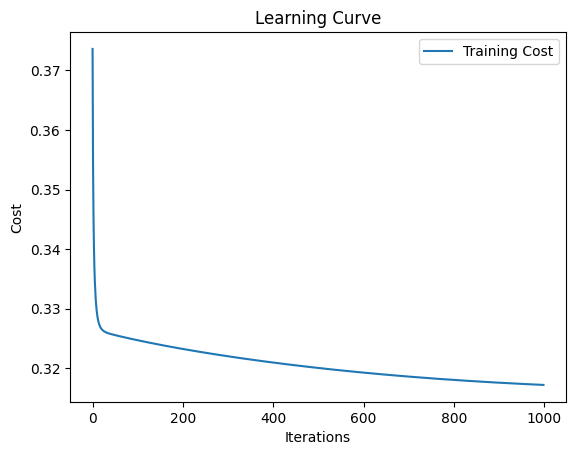

In [34]:
#plotting
plt.plot(J_hist, label="Training Cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Learning Curve")
plt.legend()
plt.show()

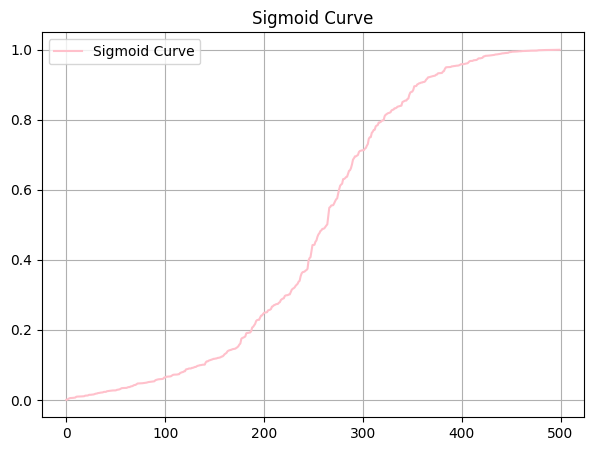

In [35]:
#plotting sigmoid curve
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(sorted(sigmoid_predictions), color="pink", label="Sigmoid Curve")
ax.set_title("Sigmoid Curve")
ax.grid(True)
ax.legend()
plt.show()

In [36]:
#calc error
predictions = np.array(predictions)
TP = np.sum((y_test==1) & (predictions==1))
TN = np.sum((y_test==0) & (predictions==0))
FP = np.sum((y_test==0) & (predictions==1))
FN = np.sum((y_test==1) & (predictions==0))
cm = [[TP, FP], [FN, TN]]
print(f"The model is {(TP+TN)/len(y_test)*100}% accurate.")

The model is 89.2% accurate.
